# Tree-Structured Parzen Estimator + BO from scratch

As a reminder, the goal of Bayesian Optimization (BO) is to find the input $x$ that maximizes or minimizes an unknown function $y=f(x)$, using as few evaluations as possible. BO searches through the input space, starting with an initial (prior) belief about where the best inputs are. Given more data, BO updates these beliefs to more accurately model the unknown function and selects new input points that are likely to perform well, balancing exploration (trying new areas) and exploitation (refining known good areas).

Tree-structured Parzen Estimator (TPE) is one way to implement BO. Unlike **Gaussian Process (GP)-based BO, which models $p(y | x)$** (i.e., the distribution over function values given observed inputs), **TPE models $p(x | y)$**, the distribution over input values conditioned on observed outcomes. 
- In GP-based BO, the surrogate is a **regression model**, which is a type of **discriminative model**. Discriminative models learn $p(y | x)$ - they predict the distribution of outcome $y$ from an input $x$. In other words, they answer: Given an input $x$, what do I expect the output to be?
- TPE, by contrast, is a **generative model**, which models $p(x|y)$, the distribution of inputs $x$ that tend to result in particular observed outcomes $y$. These models are "generative" in the sense that they can **generate new candidate inputs** by sampling from the input distribution associated with certain types of outcomes. In other words, they answer: Given observed outcomes $y$, what kinds of inputs tend to produce them?
  - In practice, TPE generates candidate inputs by sampling only from the distribution of inputs associated with **good outcomes**. I'll elaborate on this later.

I was confused at first because TPE builds a model of $p(x∣y)$. It seemed strange to use this to drive optimization, since it feels backward - shouldn’t we be modeling the function?
- While TPE doesn't directly predict $y$ for a given $x$, it still serves as a surrogate: it estimates **where in the input space** good values of $y$ are likely to occur. In this way, it **approximates the objective function indirectly** by learning to generate promising inputs based on past observations.
- This inversion avoids the need for a smooth, continuous function mapping from $x->y$, which makes TPE naturally compatible with discrete, categorical, hierarchical, or conditional variables (things GPs struggle with, typically encountered in hyperparameter tuning).


## TPE Semi-Formal Definition
TPE splits observed outcomes into two groups using a threshold $y*$, and fits two separate nonparametric probability distributions (usually KDEs) over the corresponding input values:

- $l(x) = P(x \mid y < y^*)$: distribution of inputs associated with **good outcomes**  
- $g(x) = P(x \mid y \geq y^*)$: distribution of inputs associated with **bad outcomes**

To select the next candidate input, TPE samples many candidates from $l(x)$, then chooses one that maximizes the following ratio:
$$\frac{l(x)}{g(x)}$$
This ratio serves as TPE's **acquisition function**. The idea is to prefer new candidate inputs that are **likely under $l(x)$** (similar to inputs that performed well) and **unlikely under $g(x)$** (dissimilar to inputs that performed poorly). 

Notes:
- The TPE literature typically assumes the objective function is being **minimized**. Therefore, "good" outcomes are those less than the threshold $y^*$.
- $y$ refers to **observed** objective function values.
- The $\frac{l(x)}{g(x)}$ ratio is a proxy for/is proportional to **Expected Improvement**. 

## Summary of TPE-BO algorithm
1. Make some initial observations $\{(x_i, y_i)\}^N_{i=1}$
2. Split the observations into two groups based on a quantile threshold: good inputs have low $y$, and bad inputs have high $y$.
3. Fit KDEs ($l(x)$ and $g(x)$) over the input values in both groups.
4. Sample candidate inputs $x$ from $l(x)$, choose the one that maximizes the ratio acquisition function.
5. Evaluate the true objective at the chosen input, add it to the dataset, and repeat the process (step 2 onwards)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import openml
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

np.random.seed(0)

## Example with 1D input
In this example, our goal is to minimize the quadratic function.
Our prior over the input space is effectively a uniform distribution (i.e., all inputs are likely to produce a good outcome). 

### Initialization
We begin by observing 30 initial points...

X_train:  [-8.57927884 -8.25741401 -9.59563205  6.65239691  5.56313502  7.40024296
  9.57236684  5.98317128 -0.77041275  5.61058353 -7.63451148  2.79842043
 -7.13293425  8.89337834  0.43696644 -1.7067612  -4.70888776  5.48467379
 -0.87699336  1.36867898 -9.62420399  2.35270994  2.24191445  2.33867994
  8.87496157  3.63640598 -2.80984199 -1.25936092  3.95262392 -8.79549057]
y_train:  [73.60402535 68.18488607 92.07615446 44.25438466 30.94847124 54.76359594
 91.63020701 35.79833862  0.59353581 31.4786475  58.28576558  7.83115688
 50.87875104 79.09217832  0.19093967  2.91303379 22.17362392 30.08164657
  0.76911735  1.87328214 92.62530247  5.53524407  5.02618042  5.46942385
 78.76494287 13.22344847  7.895212    1.58598994 15.62323584 77.36065432]


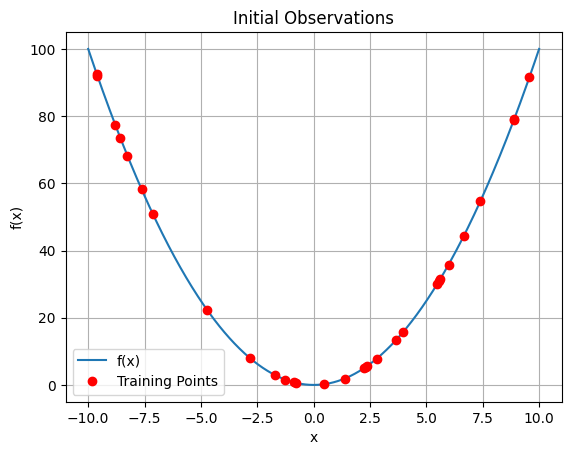

In [11]:
n_train = 30 # Number of initial points

def objective(X):
    return X**2

# Observe n_train random points uniformly within bounds
X_train = np.random.uniform(-10, 10, size=n_train)
y_train = objective(X_train)

print("X_train: ", X_train)
print("y_train: ", y_train)

x_plot = np.linspace(-10, 10, 1000).reshape(-1, 1)
plt.plot(x_plot, objective(x_plot), label="f(x)")
plt.plot(X_train, y_train, 'ro', label="Training Points")
plt.title("Initial Observations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

### Split dataset
We then compute a threshold to split the observed dataset. Here I'm using the **linear splitting rule**, which corresponds to (notation taken from Watanabe 2023):
$$\gamma := \Gamma(N) = \beta_1, \quad \beta_1 \in (0, 1]$$
This uses a fixed fraction of the best-performing points (**lowest** $y$, since we're minimizing the objective), regardless of $N$, the current number of observations. 

For example, given $N=20$ and $\beta_1=0.2$, we get $\gamma=0.2$, so we select the top 4 inputs out of 20 as the "good" group.

---

Alternatively, if we want to emphasize exploration, we can use the **square root splitting rule**:
$$\gamma := \Gamma(N) = \frac{\beta_2}{\sqrt{N}}, \quad \beta_2 \in (0, \sqrt{N}]$$
This keeps $\gamma$ small and shrinks it over time as $N$ increases (i.e., as more points are observed).
- This promotes exploration because the KDE for $l(x)$ is based on very few points.
- Many candidate samples (drawn from $l(x)$), even if drawn near its peak, will also lie in regions where $g(x)$ is high, since the "bad" KDE is broader.
- As a result, the ratio $\frac{l(x)}{g(x)}$ is low or flat across candidates. There is no standout input to exploit.

For example, with $N=10$ and $\beta=0.25$, we get:
$$\gamma = \frac{0.25}{\sqrt{10}} \approx 0.079$$
So only the top 1 input is used to build $l(x)$.  


In both splitting rules, smaller beta values generally lead to more exploration and less exploitation by lowering confidence in the model’s current estimate of the optimum.

Threshold:  4.603551095746319


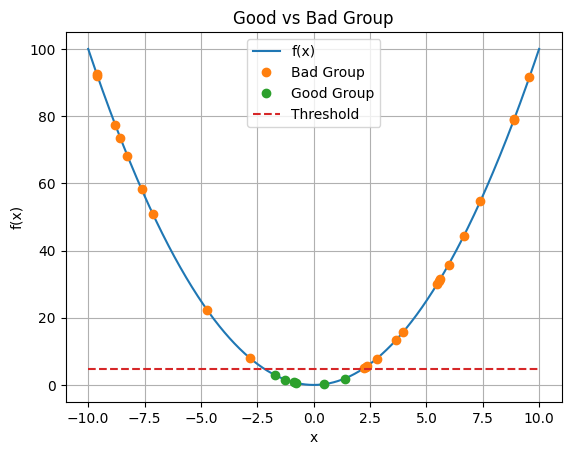

In [12]:
beta = 0.2 # [0, 1], top 20% of inputs go into l(x)

# Compute threshold
threshold = np.quantile(y_train, beta)
print("Threshold: ", threshold)

# Split into good and bad groups
l_x = X_train[y_train < threshold].reshape(-1,1)
g_x = X_train[y_train >= threshold].reshape(-1,1)
# print("Good group (l_x): ", l_x) # 20%
# print("Bad group (g_x): ", g_x) # 80%

x_plot = np.linspace(-10, 10, 1000).reshape(-1, 1)
plt.plot(x_plot, objective(x_plot), label="f(x)")
plt.plot(g_x, objective(g_x), 'o', label="Bad Group")
plt.plot(l_x, objective(l_x), 'o', label="Good Group")
plt.plot(x_plot, [threshold for _ in range(1000)], linestyle='--', label="Threshold")
plt.title("Good vs Bad Group")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

### Fitting KDEs
We can construct a standard Kernel Density Estimator (KDE) using the following probability density functions:
$$l(x) = \frac{1}{N^{(l)}} \sum^{N^{(l)}}_{n=1} k(x,x_n)$$
$$g(x) = \frac{1}{N^{(g)}} \sum^{N^{(g)}}_{n=1} k(x,x_n)$$
Where:
- $x$ is the point where we evaluate the density
- $x_n$ is an observed input (from the "good" group for $l(x)$, or the "bad" group for $g(x)$)
- $k(x, x_n)$ is the kernel function, typically a Gaussian/RBF kernel
- $N^{(l)}$, $N^{(g)}$ are the number of observed samples in the good and bad groups respectively

As expected, the closer $x$ is to a previously observed point $x_n$, the higher the resulting density.

In our demo, the estimated KDE $l(x)$ is concentrated around $x = 0$, which corresponds to the minimum of the quadratic function, exactly as we would expect.

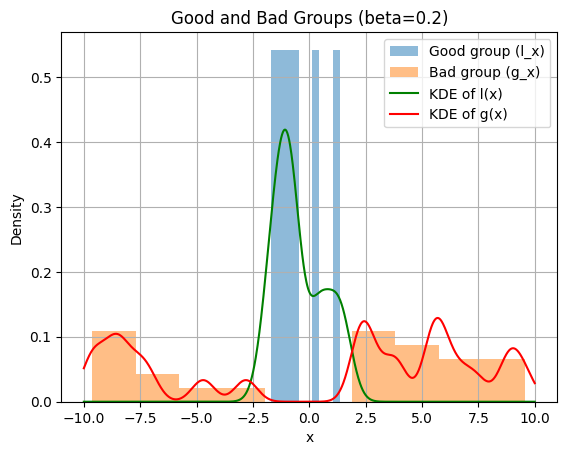

In [13]:
# We use the Gaussian (RBF) kernel
kde_bandwidth = 0.5 # controls how smooth the curve is

l_kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth)
g_kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth)
l_kde.fit(l_x)
g_kde.fit(g_x)

# Create a grid for plotting
x_plot = np.linspace(-10, 10, 1000).reshape(-1, 1)
# score_samples return the log density of the PDF at each point in x_plot
l_log_dens = l_kde.score_samples(x_plot) 
g_log_dens = g_kde.score_samples(x_plot)

plt.hist(l_x, bins=10, density=True, alpha=0.5, label="Good group (l_x)")
plt.hist(g_x, bins=10, density=True, alpha=0.5, label="Bad group (g_x)")
# exponentiate to get the actual density values...
plt.plot(x_plot, np.exp(l_log_dens), label="KDE of l(x)", color='green')
plt.plot(x_plot, np.exp(g_log_dens), label="KDE of g(x)", color='red')
plt.title(f"Good and Bad Groups (beta={beta})")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

Alternatively, Watanabe (2023) presents the following KDE equations:
$$l(x) = w_0^{(l)} p_0(x) + \sum_{n=1}^{N^{(l)}} w_n^{(l)} k(x, x_n \mid b^{(l)})$$
$$g(x) = w_0^{(g)} p_0(x) + \sum_{n=1}^{N^{(g)}} w_n^{(g)} k(x, x_n \mid b^{(g)})$$
Where:
- $x$ is the candidate input point where we evaluate the density
- $x_n$ is an observed input from either the "good" or "bad" group
- $k(x,x_n \mid b^{(l)})$ is the kernel function (typically Gaussian) with bandwidth $b^{(l)}$
- $p_0(x)$ is the prior distribution over inputs (often uniform)
- $w_0^{(l)}, w_n^{(l)}$ are non-negative weights assigned to the prior and each kernel, respectively

Optuna employs a weighting algorithm to recompute the weights for every iteration. In the simplest case, **uniform weighting** is used:
 $$w_n^{(l)} = \frac{N}{N^{(l)} + 1} \forall n$$
 $$w_0^{(l)} = \frac{1}{N^{(l)} + 1}$$
For each KDE, all weights sum up to 1. For example, $$w_0^{(l)} + \sum^{N^{(l)}}_{n=1} w^{(l)}_n = 1$$

Uniform weighting simply gives equal importance to all points. Another strategy is **old decay weighting**, which gradually down-weights older observations to emphasize recent data.



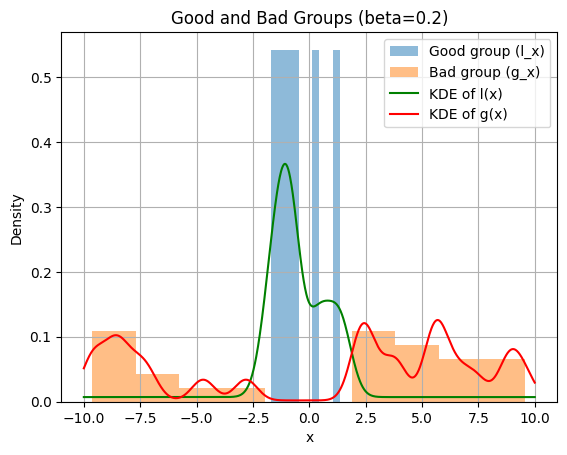

In [14]:
def evaluate_kde_with_prior(kde, X_eval, prior_density, n_samples):
    """
    Construct a KDE with a uniform prior component, as described in Watanabe (2023),
    and evaluates the KDE at points X_eval. 
    This is equivalent to KernelDensity's score_samples function
    kde: a fitted KernelDensity object
    n_samples: int, number of points used to fit the KDE (size of the good/bad group)
    X_eval: (n_eval, n_features) array of points to be evaluated
    prior_density: float, p0(x), e.g., typically 1 / (upper_bound - lower_bound) for uniform prior over a domain

    Returns density, array of shape (n_eval, ) containing the estimated densities at each point. 
    """
    # kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth)
    # kde.fit(X)
    log_kde_vals = kde.score_samples(X_eval) # log density
    kde_vals = np.exp(log_kde_vals)

    # Compute weights (uniform)
    weight_kde = n_samples / (n_samples + 1)
    weight_prior = 1 / (n_samples + 1)

    return weight_kde * kde_vals + weight_prior * prior_density
    
l_kde2 = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth)
g_kde2 = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth)
l_kde2.fit(l_x)
g_kde2.fit(g_x)

prior_density = 1 / 20 # 10 - (-10)
l_vals = evaluate_kde_with_prior(l_kde2, x_plot, prior_density, n_samples=len(l_x))
g_vals = evaluate_kde_with_prior(g_kde2, x_plot, prior_density, n_samples=len(g_x))

plt.hist(l_x, bins=10, density=True, alpha=0.5, label="Good group (l_x)")
plt.hist(g_x, bins=10, density=True, alpha=0.5, label="Bad group (g_x)")
plt.plot(x_plot, l_vals, label="KDE of l(x)", color='green')
plt.plot(x_plot, g_vals, label="KDE of g(x)", color='red')
plt.title(f"Good and Bad Groups (beta={beta})")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

### Choosing candidate input

The next candidate is x=[-0.32417581], y=[0.10508996]


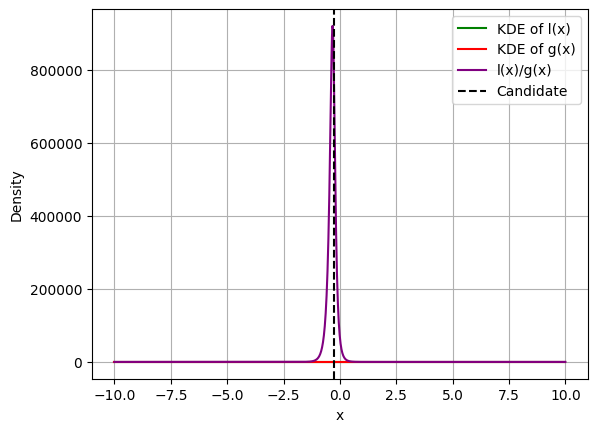

In [15]:
# Draw 1000 samples from the "good" KDE
# We expect this to mostly lie around regions where good performance occurred
candidates = l_kde.sample(1000)

# Compute ratio scores: l(x)/g(x) = exp(log_l - log_g)
# "score_samples" returns log densities
ratios = np.exp(l_kde.score_samples(candidates) - g_kde.score_samples(candidates))
# ratios = l_kde.score_samples(candidates) - g_kde.score_samples(candidates)

# Pick the next input with the highest score
best_x = candidates[np.argmax(ratios)]
best_y = objective(best_x)

print(f"The next candidate is x={best_x}, y={best_y}")
ratios_plot = np.exp(l_kde.score_samples(x_plot) - g_kde.score_samples(x_plot))
plt.plot(x_plot, np.exp(l_log_dens), label="KDE of l(x)", color='green')
plt.plot(x_plot, np.exp(g_log_dens), label="KDE of g(x)", color='red')
plt.plot(x_plot, ratios_plot, label="l(x)/g(x)", color='purple')
plt.axvline(x=-0.25958977, color='black', linestyle='--', label='Candidate')
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

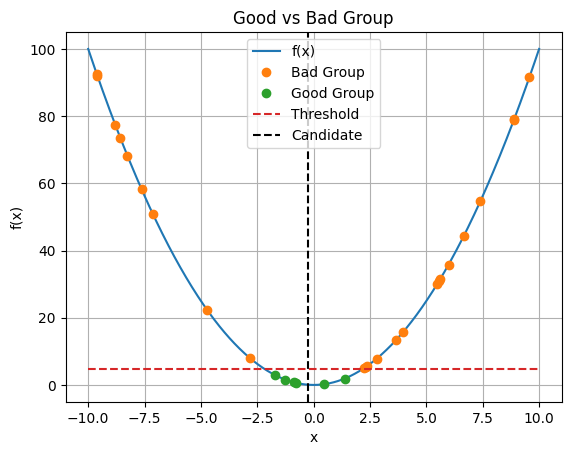

In [16]:
plt.plot(x_plot, objective(x_plot), label="f(x)")
plt.plot(g_x, objective(g_x), 'o', label="Bad Group")
plt.plot(l_x, objective(l_x), 'o', label="Good Group")
plt.plot(x_plot, [threshold for _ in range(1000)], linestyle='--', label="Threshold")
plt.axvline(x=-0.25958977, color='black', linestyle='--', label='Candidate')
plt.title("Good vs Bad Group")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

### Repeat the process
After obtaining a candidate point, you add it to the dataset and repeat the process, reconstructing the KDEs with the updated data each time. Once the process is complete, you return the lowest observed $y$ value (if minimizing) across all iterations.

## Example with mixed-type variables in input
As of now, our implementation does not yet support categorical or conditional variables, nor multi-dimensional inputs.
In this example, we extend our code to handle 2D inputs consisting of one numerical variable (**n_estimators**) and one categorical variable (**criterion**) for hyperparameter tuning of a RandomForestClassifier.

According to Watanabe, there are two ways to handle multi-dimensional inputs. The first is to use what they refer to as a **Univariate KDE**:

Given $N$ samples $\{x_n\}_{n=1}^N$, each of dimension $D$, the univariate KDE for a point $x = (x_1, x_2, \dots, x_D)$ is:
$$
p(x \mid \{x_n\}_{n=1}^N) = \frac{1}{N^D} \prod_{d=1}^{D} \sum_{n=1}^{N} k_d(x_d, x_{n,d} \mid b)
$$

where:
- $x$ is the input being evaluated, and $x_d$ is its value in the $d$-th dimension
- $x_n$ is the $n$-th observation, $x_{n,d}$ is its value in the $d$-th dimension
- $k_d(x_d, x_{n,d} \mid b)$ is a one-dimensional kernel (typically Gaussian, if numeric) centered at $x_{n,d}$ (the observed value in dimension $d$) with bandwidth $b$.

Essentially:
- For each dimension $d$, you construct a 1D KDE over the training/sampled values in that dimension.
- To compute the density of $x$, you take the product of the KDE values across all dimensions evaluated at the corresponding $x_d$.  

---

The second method is **Multivariate KDE**, which accounts for possible interactions/correlations between variables:

Given $N$ samples $\{x_n\}_{n=1}^N$, each of dimension $D$, the multivariate KDE at a point $x \in \mathbb{R}^D$ is:

$$
p(x|\{x_n\}_{n=1}^N) := \frac{1}{N} \sum_{n=1}^{N} \prod_{d=1}^{D} k_d(x_d, x_{n,d}|b).
$$

How it works:
- For each sample $x_n$, compute a joint similarity score by multiplying kernel values across all dimensions
  - Keeping in mind each kernel $k_d$ measures how similar the query value $x_d$ is to the sample value $x_{n,d}$ in a given dimension $d$
- The final density estimate for $x$ is the average of these joint scores across all samples.

Doubts:
- I believe this equation assumes independence across dimensions/variables? I don't think it captures any covariance.

### Kernel choice
For numerical values, Gaussian kernels are typically sufficient. For categorical values, Watanabe recommends the following Aitchison-Aitken kernel to measure similarity between categorical values:
$$
k_d(x, x_n \mid b) = 
\begin{cases} 
1 - b & \text{if } x = x_n \\ 
\frac{b}{C - 1} & \text{otherwise}
\end{cases}
$$

where:
- $x$, $x_n$ are the categorical values being compared
- $C$ is the number of categories
- $b \in [0,1)$ is the bandwidth parameter that controls the degree of exploration
  - if $b$ is small, the kernel favors matching values (less exploration).
  - if $b$ is large, the kernel spreads probability more evenly across all values (more exploration)

Basically, if the two values are equal, the kernel returns high similarity. If they are different, the similarity is distributed evenly among the remaining categories. 

In [5]:
# Idk how to handle bandwidth here will revisit that later 
def gaussian_kernel(x, x_n, bandwidth):
    """
    Gaussian kernel for numerical values
    Wrapper for scipy.stats.norm.pdf for consistency purposes 
    """
    return norm.pdf(x, loc=x_n, scale=bandwidth)

def aitchison_aitken_kernel(x, x_n, categories, bandwidth):
    """
    Aitchison-Aitken kernel for categorical values
    """
    if x == x_n:
        return 1 - bandwidth
    else:
        return bandwidth / (len(categories) - 1)


def univariate_kde(x, samples, param_config, bandwidth):
    """
    Compute the density of x by summing kernels across samples per dimension, then multiplying across dimensions.
    x: a single D-th dimension point
    samples: a list of D-th dimension observed points 
    """
    D = len(x)
    N = len(samples)
    density = 1.0
    for dim in range(D):
        param_type = param_config[dim]['type']
        # Compute kernel sum for x in this dimension
        kernel_sum = 0.0
        for sample in samples:
            if param_type == 'int' or param_type == 'float':
                kernel_sum += gaussian_kernel(x[dim], sample[dim], bandwidth)
            if param_type == 'cat':
                kernel_sum += aitchison_aitken_kernel(x[dim], sample[dim], param_config[dim]['bounds'], bandwidth)
        # Compute KDE product 
        density *= kernel_sum / N
    return density 


def multivariate_kde(x, samples, param_config, bandwidth):
    """
    Compute the density of x by taking the product of kernels across dimensions per sample, 
    then averages across samples.
    """
    D = len(x)
    N = len(samples)
    density = 0.0
    for sample in samples:
        kernel_product = 1.0
        for dim in range(D):
            param_type = param_config[dim]['type']
            if param_type == 'int' or param_type == 'float':
                kernel_product *= gaussian_kernel(x[dim], sample[dim], bandwidth)
            if param_type == 'cat':
                kernel_product *= aitchison_aitken_kernel(x[dim], sample[dim], param_config[dim]['bounds'], bandwidth)
        density += kernel_product
    return density / N
            


### KDE Bandwidth
Bergstra et al. (2011) applied a heuristic to recompute the bandwidth for every iteration.
small b_min leads to stronger exploitation, larger b_min leads to stronger exploration 


In [ ]:
# bandwidth heuristic

In [17]:
x_train = 30
param_names = ['n_estimators', 'criterion']
param_config = {'n_estimators': {'bounds': (50, 500), 'type': 'int'},
                     'criterion': {'bounds': ("gini", "entropy", "log_loss"), 'type': 'cat'}}

def random_sample(param_config, count):
    """
    Randomly samples 'count' inputs from the hyperparameter space
    """
    X = []
    for _ in range(count):
        sample = []
        for param in param_config.values():
            if param['type'] == 'int':
                sample.append(np.random.randint(*param['bounds']))
            elif param['type'] == 'float':
                sample.append(np.random.uniform(*param['bounds']))
            elif param['type'] == 'cat':
                sample.append(np.random.choice(param['bounds']))
        X.append(sample)
    return X

def vector_to_param_dict(values, param_names, param_config):
    """
    Converts a list of hyperparameter values into a dictionary using the provided configuration.
    
    Parameters:
    - values: List of values, one for each hyperparameter.
    - hyperparam_names: List of hyperparameter names.
    - config: Dictionary mapping each hyperparameter to its bounds and type.

    Returns:
    - A dictionary mapping hyperparameter names to properly typed values.
    """
    assert len(param_names) == len(values)
    param_dict = {}
    for name, value in zip(param_names, values):
        param_dict[name] = value
    return param_dict

# Generate initial samples
space = []
samples = random_sample(param_config, n_train)
for sample in samples:
    space.append(vector_to_param_dict(sample, param_names, param_config))
print(space)

[[53, np.str_('gini')], [132, np.str_('gini')]]
{'n_estimators': 53, 'criterion': np.str_('gini')}
[{'n_estimators': 185, 'criterion': np.str_('log_loss')}, {'n_estimators': 399, 'criterion': np.str_('log_loss')}, {'n_estimators': 223, 'criterion': np.str_('log_loss')}, {'n_estimators': 181, 'criterion': np.str_('log_loss')}, {'n_estimators': 116, 'criterion': np.str_('entropy')}, {'n_estimators': 202, 'criterion': np.str_('log_loss')}, {'n_estimators': 372, 'criterion': np.str_('log_loss')}, {'n_estimators': 418, 'criterion': np.str_('log_loss')}, {'n_estimators': 159, 'criterion': np.str_('gini')}, {'n_estimators': 427, 'criterion': np.str_('entropy')}, {'n_estimators': 346, 'criterion': np.str_('log_loss')}, {'n_estimators': 486, 'criterion': np.str_('entropy')}, {'n_estimators': 440, 'criterion': np.str_('gini')}, {'n_estimators': 439, 'criterion': np.str_('gini')}, {'n_estimators': 124, 'criterion': np.str_('entropy')}, {'n_estimators': 406, 'criterion': np.str_('log_loss')}, {'n_